<img src="https://raw.githubusercontent.com/determined-ai/determined/master/determined-logo.png" align='right' width=150 />

# Building a Pedestrian Detection Model with Determined

<img src="https://www.cis.upenn.edu/~jshi/ped_html/images/PennPed00071_1.png" width=400 />


This notebook will walk through the benefits of building a Deep Learning model with Determined.  We will build an object detection model trained on the [Penn-Fudan Database for Pedestrian Detection and Segmentation](https://www.cis.upenn.edu/~jshi/ped_html/).


# Table of Contents


<font size="3">
<ol>
  <li>Building a model the "old" way
    <ol>
      <li>Building a model</li>
      <li>Loading a dataset</li>
      <li>Training a model</li>
    </ol>
  </li>
  <li>Building a model with Determined
    <ol>
      <li>Single GPU training</li>
      <li>Cluster-scale multi-GPU training</li>
      <li>Adapative hyperparameter search</li>
    </ol>
  </li>
</ol>
</font>

### Setup: Imports

In [1]:
import determined as det
import os
import torch
import torchvision
from tqdm.notebook import trange, tqdm
import numpy as np

In [2]:
%matplotlib inline

# Building a Model

We'll start by building a FasterRCNN model with a ResNet-50 backbone. ([Paper](https://arxiv.org/abs/1506.01497), [PyTorch Source](https://github.com/pytorch/vision/tree/master/torchvision/models/detection))  There are only 2 classes in this dataset (Pedestrian / Background), so the model is quite simple.

In [3]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

## Data Loading

Next we'll download the data (using some included helper functions that can be found in `data.py`), and build PyTorch `DataLoader`'s for training.

In [4]:
from data import download_data, PennFudanDataset, get_transform, collate_fn

data_url = "https://determined-ai-public-datasets.s3-us-west-2.amazonaws.com/PennFudanPed/PennFudanPed.zip"
download_directory = "/tmp/PennData/"
download_data(
    download_directory=download_directory, 
    data_config={"url": data_url},
)

In [5]:
from torch.utils.data import DataLoader

dataset = PennFudanDataset(os.path.join(download_directory, "PennFudanPed"), get_transform())

# Split 80/20 into training and validation datasets.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
dataset_train, dataset_val = torch.utils.data.random_split(
    dataset, [train_size, test_size]
)

train_loader = DataLoader(dataset_train, batch_size=2, collate_fn=collate_fn, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=2, collate_fn=collate_fn, shuffle=False)

We can visualize an example from the dataset to sanity check our work:

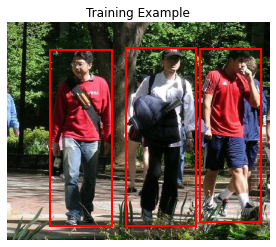

In [6]:
from data import draw_example
image, label = dataset_train[0]
draw_example(image.permute(1,2,0).numpy(), label, title="Training Example")

## Training your Model

Finally, we'll build a simple training loop and train our model for one epoch.  This is a relatively small dataset, so this shouldn't take too long on a GPU.

In [7]:
lr = 0.005
momentum = 0.9
decay =  0.0005

In [8]:
optimizer = torch.optim.SGD(
                model.parameters(),
                lr=lr,
                momentum=momentum,
                weight_decay=decay,
            )

NUM_BATCHES = 4
train_loop = tqdm(range(NUM_BATCHES), desc=f"Training {NUM_BATCHES} Batches")
for _ in train_loop:
    images, targets = next(iter(train_loader))
    optimizer.zero_grad()
    losses = model(list(images), list(targets))
    total_loss = sum([losses[l] for l in losses])
    total_loss.backward()
    optimizer.step()


# Real World Challenges

<font size="4">Modeling is almost never this easy in the real world.  Often the following story plays out in one way or another: </font>
<font size="4">
<ul style="margin-top: 15px">
  <li style="margin-bottom: 10px">Change data source</li>
  <li style="margin-bottom: 10px">Hand tune some hyperparamters</li>
  <li style="margin-bottom: 10px">Write some hyperparamter search code</li>
  <li style="margin-bottom: 10px">Write some single-node distributed training code</li>
  <li style="margin-bottom: 10px">Build a multi-node distributed training cluster</li>
  <li style="margin-bottom: 10px">Build code for multi-node distributed training</li>
  <li style="margin-bottom: 10px">Layer in some fault tolerance</li>
  <li>Find a way to track all of your experiments (with your team)</li>
</ul>
</font>

<font size=6><b>Scaled Experimentation with Determined</b></font>

Determined makes it just as easy to scale your experiments as it was to train your proof of concept model.  Let's step through what's possible:

## Configure your Experiment

With Determined, you simply need to describe the experiment you'd like to conduct.  Here we'll specify a simple, single GPU training with fixed hyperparameters.  Instructions for how to configure different types of experiments [can be found in the Determined documentation.](https://docs.determined.ai/latest/how-to/index.html)

In [9]:
import yaml

config = {
    "description": "pedestrian_detection_single_gpu",
    "data": { 
        "url": "https://determined-ai-public-datasets.s3-us-west-2.amazonaws.com/PennFudanPed/PennFudanPed.zip"
    },
    "hyperparameters": {
        "learning_rate": 0.005,
        "momentum": 0.9,
        "weight_decay": 0.0005,
        "global_batch_size": 2,
    },
    "searcher": {
        "name": "single",
        "metric": "val_avg_iou",
        "max_steps": 20,
        "smaller_is_better": False,
    },
    "entrypoint": "model_def:ObjectDetectionTrial",
    "min_validation_period": 1,
    "batches_per_step": 20,
}

with open('train.yaml', 'w') as config_file:
   yaml.dump(config, config_file)

## Create your Experiment

Now that you've described your experiment, you'll simply need to use the command line interface to submit it to the Determined Cluster.  

In [10]:
determined_master = '34.82.151.215:8080'

In [11]:
!det -m {determined_master} experiment create train.yaml .

Preparing files (/Users/davidhershey/Repos/GitHub/determined/examples/official/demo) to send to master... 715.1KB and 12 files
Created experiment 9


## Scaling up to Distributed Training

Determined makes it trivial to move from single-GPU to multi-GPU (and even multi-node) training. Here we'll simply modify the config above to request 16 GPUs instead of 1, and increase the global batch size to increase the data throughput 

In [12]:
distributed_config = config
distributed_config['description'] = "distributed_training"

# Request 16 GPUs
distributed_config['resources'] = {'slots_per_trial': 16}

# Batch size: 2 images / GPU
distributed_config['hyperparameters']['global_batch_size'] = 32

# multiply learning rate by number of slots
distributed_config['hyperparameters']['learning_rate'] = 0.08

with open('distributed.yaml', 'w') as config_file:
   yaml.dump(distributed_config, config_file)

In [13]:
!det -m {determined_master} experiment create distributed.yaml .

Preparing files (/Users/davidhershey/Repos/GitHub/determined/examples/official/demo) to send to master... 715.4KB and 12 files
Created experiment 10


## Adaptive Hyperparameter Search

Frequently, getting just a few extra percentage points of accuracy can make or break a model in production.  The best way to improve your model is with hyperparamter tuning.  Determined provides sophisticated hyperparameter tuning (based on the [Hyperband](https://arxiv.org/abs/1603.06560) algorithm), with just a little extra configuration work.  Here we'll set up the hyperparamter search space and tell Determined to perform an 'adaptive' hyperparamter search

In [14]:
search_config = config
search_config['resources'] = {'slots_per_trial': 1}
search_config['description'] = "hyperparamter_tuning"

search_config['hyperparameters'] = {
    'learning_rate': {
        'type': 'log',
        'minval': -4,
        'maxval': -2,
        'base': 10,
    },
    'momentum': {
        'type': 'double',
        'minval': 0.7,
        'maxval': 0.95,
    },
    'global_batch_size': 2,
    'weight_decay': .0005,
}

search_config['searcher'] = {
    'name': 'adaptive_simple',
    'metric': 'val_avg_iou',
    'max_steps': 20,
    'smaller_is_better': False,
    'max_trials': 24,
}

with open('search.yaml', 'w') as config_file:
   yaml.dump(search_config, config_file)

In [15]:
!det -m {determined_master} experiment create search.yaml .

Preparing files (/Users/davidhershey/Repos/GitHub/determined/examples/official/demo) to send to master... 715.8KB and 12 files
Created experiment 11


# Model Export

After training, we'll want to actually use our model in some sort of system.  Here we'll briefly show how the best-performing model can be retreived from Determined, and how we can use that model to make predictions on some hold-out data.

In [16]:
experiment_id = 6

In [17]:
from determined.experimental import Determined
import torch
checkpoint = Determined(master=determined_master).get_experiment(experiment_id).top_checkpoint()
checkpoint_path = checkpoint.download()
model = checkpoint.load(map_location=torch.device('cpu'))

/Users/davidhershey/.virtualenvs/det/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/davidhershey/.virtualenvs/det/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see ht

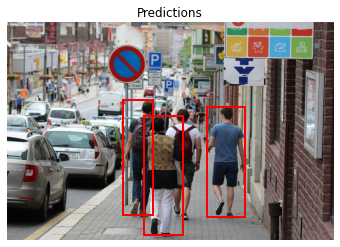

In [21]:
from data import load_and_transform_image
test_image = load_and_transform_image('test.jpg')
with torch.no_grad():
    outputs = model(test_image.unsqueeze(0))[0]

def filter_boxes(boxes, scores, threshold=0.9):
    cutoff = 0
    for i, score in enumerate(scores):
        if score < threshold:
            break
        cutoff = i
    return boxes[:cutoff]

boxes = filter_boxes(outputs['boxes'], outputs['scores'])
draw_example(test_image.permute(1,2,0).numpy(), {'boxes': boxes}, title="Predictions")


# Collaboration

Determined is built to collaborate with a team -- this includes sharing experiments, results, and resources.  Here we'll launch two more experiment, one as ourself and one on behalf of another user named Alice.  We'll see how the cluster separates the jobs, and shares resources such that they both can progress their experiments.

 _Submit an experiment as myself_

In [ ]:
!det -m {determined_master} experiment create search.yaml .

_Switch to terminal to change users to Alice_

In [19]:
!det -m {determined_master} experiment create search.yaml .

Preparing files (/Users/davidhershey/Repos/GitHub/determined/examples/official/demo) to send to master... 989.9KB and 12 files
Created experiment 12
